In [67]:
import pickle
import numpy as np 
from pathlib import Path 

import matplotlib.pyplot as plt 
from cycler import cycler 
from matplotlib import cm

nice5 = plt.get_cmap("rainbow")(np.linspace(0,1,5))
plt.rcParams["axes.prop_cycle"] = cycler(color=nice5)
plt.rcParams['font.family']      = 'serif'
plt.rcParams['mathtext.fontset'] = 'cm'

SLOPE_DIR = Path.home() / "extinction/assets/ratios/A_lambda_over_A_F212N.pickle"

In [193]:
with open(SLOPE_DIR, "rb") as f: 
    ratios = pickle.load(f)
ratios

for (det, filt), (ratio, err) in ratios.items():
    if filt == "F323N": 
        if det == "NRCB1": 
            ratio -= 0.4
        if det == "NRCB2": 
            ratio -= 0.3 
        if det == "NRCB3": 
            ratio -= 0.3 
        if det == "NRCB4": 
            ratio -= 0.4
    if filt == "F405N": 
        if det == "NRCB4": 
            ratio -= 0.1
    if filt == "F115W": 
        if det == "NRCB3": 
            ratio += 1
    if filt == "F140M": 
        if det == "NRCB3": 
            ratio += 0.7
    if filt == "F182M": 
        if det == "NRCB3": 
            ratio += 0.4
    if filt == "F115W": 
        if det == "NRCB2": 
            ratio -= 0.2
        if det == "NRCB4": 
            ratio += 0.1
    ratios[(det, filt)] = (ratio, err)

In [194]:
final = {}
for (det, filt), (ratio, err) in ratios.items():
    if det not in final:
        final[det] = {}

    label = f"A{filt}/AF212N"
    final[det][label] = (ratio, err)
with open("ratios.pickle", "wb") as f:
    pickle.dump(final, f)

In [195]:
filter_map = { 
    "F115W": 1.15, 
    "F140M": 1.40, 
    "F182M": 1.82, 
    "F212N": 2.12, 
    "F323N": 3.23, 
    "F405N": 4.05
}

NRCB1_ratios = [] 
NRCB2_ratios = [] 
NRCB3_ratios = [] 
NRCB4_ratios = []

for (det, filt), (ratio, err) in ratios.items(): 
    if det == "NRCB1": NRCB1_ratios.append([filter_map.get(filt), ratio, err]) 
    if det == "NRCB2": NRCB2_ratios.append([filter_map.get(filt), ratio, err])
    if det == "NRCB3": NRCB3_ratios.append([filter_map.get(filt), ratio, err]) 
    if det == "NRCB4": NRCB4_ratios.append([filter_map.get(filt), ratio, err]) 

NRCB1_ratios = np.asarray(NRCB1_ratios) 
NRCB2_ratios = np.asarray(NRCB2_ratios) 
NRCB3_ratios = np.asarray(NRCB3_ratios) 
NRCB4_ratios = np.asarray(NRCB4_ratios)

In [196]:
from spisea import reddening 
laws = [
    reddening.RedLawCardelli(Rv=3.1),
    reddening.RedLawRiekeLebofsky(),
    reddening.RedLawNishiyama09(),
    reddening.RedLawHosek18b(),
    reddening.RedLawNoguerasLara20()
]
methods = [
    "Cardelli89", 
    "RiekeLebofsky85", 
    "Nishiyama09",
    "Hosek18b", 
    "NoguerasLara20"
]
wavs  = [
    (1, 2.95, 20), 
    (1, 4, 4), 
    (1, 7.9, 6),
    (1, 3.54, 300), 
    (1, 2.2, 6)
]

GC_Laws = {}
for law, name, wav_tuple in zip(laws, methods, wavs):
    fn  = getattr(law, name)               
    wavelength  = np.linspace(*wav_tuple)

    A212N         = fn(wavelength=2.12, AKs=2.5)
    extinction    = fn(wavelength=wavelength, AKs=2.5)  
    GC_Laws[name] = np.vstack([wavelength, extinction / A212N]) 

# Fritz11 
fritz_law = reddening.RedLawFritz11() 
wavelength, extinction, error = fritz_law._read_Fritz11() 
mask = (wavelength < 19.5) 
wavelength = wavelength[mask] 
extinction = extinction[mask] 

A212N = fritz_law.Fritz11(wavelength=2.12, A_scale_lambda=2.5) 
fritz = np.vstack([wavelength, extinction / A212N]) 

# G23 
from dust_extinction.parameter_averages import G23 
import astropy.units as u 

extmod = G23(Rv=3.1)
x_min, x_max = extmod.x_range

lam_min = (1/x_max)      
lam_max = (1/x_min)         

wave_min_AA = (lam_min * u.um).to(u.AA).value
wave_max_AA = (lam_max * u.um).to(u.AA).value

wavelengths = np.logspace(
    np.log10(wave_min_AA),
    np.log10(wave_max_AA),
    2000
) * u.AA

A_over_AV    = extmod(wavelengths)
A_Ks_over_AV = extmod((2.17 * u.um).to(u.AA))  
A_over_AKs   = A_over_AV / A_Ks_over_AV

mask        = (wavelengths.to(u.um).value > 1) & (wavelengths.to(u.um).value < 19.5)
wavelengths = wavelengths[mask] 
A_over_AKs  = A_over_AKs[mask]

G23 = np.vstack([wavelengths.to(u.um).value, A_over_AKs])

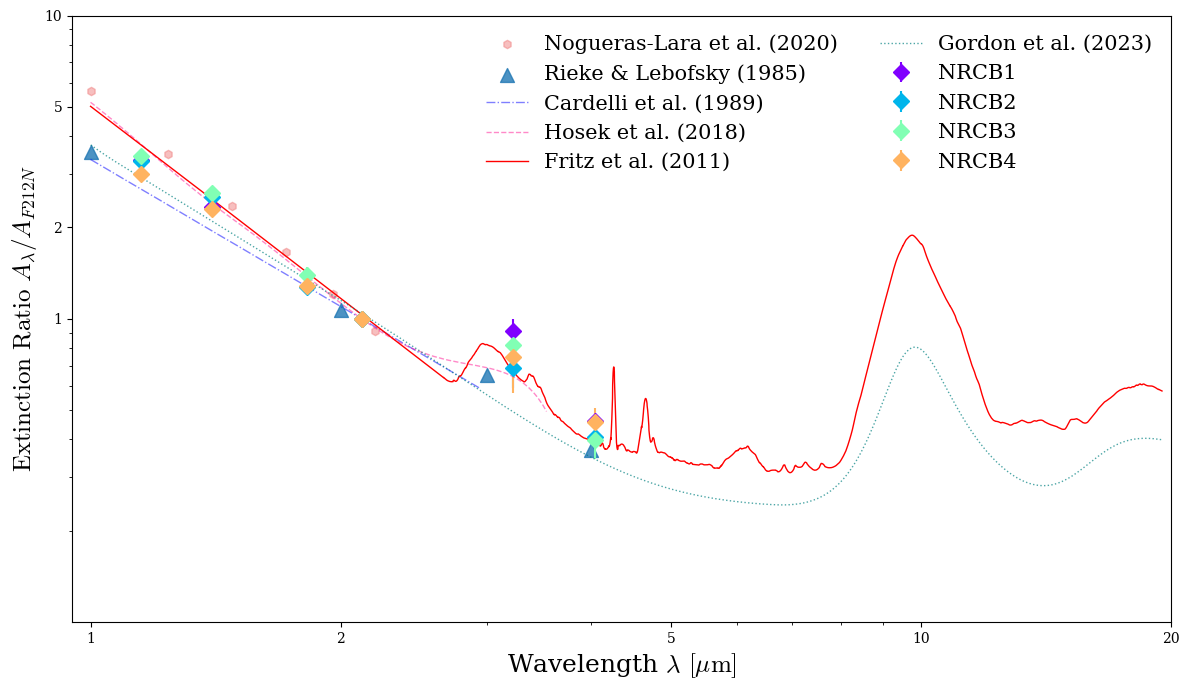

In [197]:
figure, axis = plt.subplots(figsize=(12, 7)) 

for idx, det_ratios in enumerate([NRCB1_ratios, NRCB2_ratios, NRCB3_ratios, NRCB4_ratios]):
    x    = det_ratios[:, 0] 
    y    = det_ratios[:, 1] 
    yerr = det_ratios[:, 2]
    
    plt.errorbar(
        x, y, yerr=yerr, 
        markersize=8, marker="D", 
        linestyle="none", label=f"NRCB{idx+1}" 
    )

w_ccm, r_ccm     = GC_Laws["Cardelli89"] 
w_hosek, r_hosek = GC_Laws["Hosek18b"] 
w_rieke, r_rieke = GC_Laws["RiekeLebofsky85"] 
w_nishi, r_nishi = GC_Laws["Nishiyama09"] 
w_nogue, r_nogue = GC_Laws["NoguerasLara20"]
w_fritz, r_fritz = fritz 
w_g23, r_g23     = G23

axis.scatter(
    w_nogue, r_nogue,
    color='lightcoral',         
    marker='h', 
    alpha=0.5,
    label='Nogueras-Lara et al. (2020)'
)
axis.scatter(
    w_rieke, r_rieke,
    marker='^',
    s=100,
    facecolor='tab:blue',
    alpha=0.8,
    label='Rieke & Lebofsky (1985)'
)
axis.plot(
    w_ccm, r_ccm, 
    color='b', 
    linewidth=1,
    linestyle='-.', 
    alpha=0.5, 
    label='Cardelli et al. (1989)'
)
axis.plot(
    w_hosek, r_hosek, 
    color='deeppink', 
    linewidth=1,
    linestyle='--', 
    alpha=0.5, 
    label='Hosek et al. (2018)'
) 

axis.plot(
    w_fritz, r_fritz,
    color='r',         
    linewidth=1,
    linestyle='-',
    alpha=1,
    label='Fritz et al. (2011)'
)
axis.plot(
    w_g23, r_g23, 
    color='teal', 
    linewidth=1,
    linestyle=':', 
    alpha=0.7, 
    label='Gordon et al. (2023)'
)

axis.set_xscale('log')
axis.set_yscale('log')
axis.set_ylim(0.1, 10) 
axis.set_xlim(0.95, 10)
axis.set_xticks([1, 2, 5, 10, 20])
axis.set_yticks([1, 2, 5, 10])
axis.get_xaxis().set_major_formatter(plt.ScalarFormatter())
axis.get_yaxis().set_major_formatter(plt.ScalarFormatter())
axis.set_xlabel(r'Wavelength $\lambda$ $[\mu \rm m]$', fontsize=18)
axis.set_ylabel(r'$\rm Extinction$ $\rm Ratio$ $A_\lambda / A_{F212N}$', fontsize=18)

axis.legend(loc="best", fontsize=15, frameon=False, ncol=2) 
plt.tight_layout()

plt.savefig("extinction_law.png", dpi=300)